In [58]:
# import library and load dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


In [59]:
# load dataset
data_path = '../../data/processed/data_cleaned_scaled_onehot.csv' 
data = pd.read_csv(data_path)

# form features and target
X = data.drop(['Target'], axis=1)
y = data['Target']

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Adjust the class distribution to ensure the model learns adequately about the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [60]:
# hyperparameter search for random forest

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, 40, 50],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] END .....criterion=gini, max_depth=10, n_estimators=100; total time=   0.6s
[CV] END .....criterion=gini, max_depth=10, n_estimators=100; total time=   0.6s
[CV] END .....criterion=gini, max_depth=10, n_estimators=100; total time=   0.6s
[CV] END .....criterion=gini, max_depth=10, n_estimators=100; total time=   0.6s
[CV] END .....criterion=gini, max_depth=10, n_estimators=100; total time=   0.7s
[CV] END .....criterion=gini, max_depth=10, n_estimators=100; total time=   0.7s
[CV] END .....criterion=gini, max_depth=10, n_estimators=100; total time=   0.6s
[CV] END .....criterion=gini, max_depth=10, n_estimators=100; total time=   0.7s
[CV] END .....criterion=gini, max_depth=10, n_estimators=100; total time=   0.4s
[CV] END .....criterion=gini, max_depth=10, n_estimators=100; total time=   0.4s
[CV] END .....criterion=gini, max_depth=10, n_estimators=200; total time=   0.7s
[CV] END .....criterion=gini, max_depth=10, n_

In [61]:
# use cross validation to evaluate random forest model consistency on X_train data
rf = RandomForestClassifier(n_estimators=100, max_depth=40, criterion='gini', random_state=42)
scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='recall')
print("recall mean:", scores.mean(), "reacall std:", scores.std())

recall mean: 0.6985995085995087 reacall std: 0.03815250859221799


In [ ]:
# classfication with random forest
rf = RandomForestClassifier(n_estimators=100, max_depth=40, criterion='gini', random_state=42)

# train random forest
rf.fit(X_train_resampled, y_train_resampled)

# Predict probabilities instead of classes
y_prob = rf.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (dropout)

# Adjust the decision threshold
threshold = 0.3  # Set your desired threshold here
y_pred = (y_prob >= threshold).astype(int)

# evaluate accuracy, precision, recall, f1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Recall: ', recall)
print('F1: ', f1)
print('Accuracy: ', accuracy)
print('Precision: ', precision)

# confusion matrix
print("")
print("confusion matrix: [TP, FP], [FN, TN]")
print(confusion_matrix(y_test, y_pred))


Recall:  0.8607594936708861
F1:  0.767277856135402
Accuracy:  0.8135593220338984
Precision:  0.6921119592875318

confusion matrix: [TP, FP], [FN, TN]
[[448 121]
 [ 44 272]]


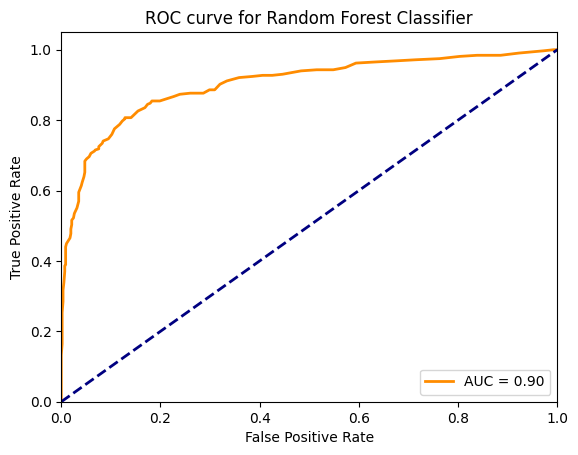

In [63]:
# build a ROC curve with different settings of decision tree
# then plot the ROC curve: false positive rate vs true positive rate
y_pred_prob = rf.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()